In [1]:
# output for 

In [2]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice
import datetime
from cmocean import cm
import copy

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [67]:
import sys
sys.path.append("../../extraspicey")
import extraspicey

In [38]:
spice.furnsh(os.path.join(os.environ.get("SPICE"), "lsk", "naif0012.tls"))
spice.furnsh(os.path.join(os.environ.get("SPICE"), "spk", "de440.bsp"))

In [267]:
# seq_key = ["earth", "jupiter", "saturn"]
# seq_name = ""
# for el in seq_key:
#     seq_name += el + "-"
# seq_name = seq_name[:-1]

# # get solar system
# ssdict = pxp.solar_system_spice()

# tof = [
#     [2/pk.DAY2YEAR, 6/pk.DAY2YEAR] for el in range(len(seq_key)-1)
# ]

# pop_list = []
# prob_list = []

# i_window = 0
# t0_iter = [
#     pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + i_window*30,
#     pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + (i_window+1)*30

# ]
# # run problem
# seq = [ssdict[el] for el in seq_key]

# prob_test = pxp.get_depart_problem(seq, t0_iter, tof)

seq_key = ["saturn", "earth"] #, "saturn"]
seq_name = ""
for el in seq_key:
    seq_name += el + "-"
seq_name = seq_name[:-1]

# get solar system
ssdict = pxp.solar_system_spice()

tof = [
    [2/pk.DAY2YEAR, 6/pk.DAY2YEAR] for el in range(len(seq_key)-1)
]

pop_list = []
prob_list = []

i_window = 0
t0_iter = [
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + i_window*30,
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + (i_window+1)*30

]
# run problem
seq = [ssdict[el] for el in seq_key]

prob_test = pxp.get_depart_problem(seq, t0_iter, tof)

In [268]:
#xEJS = np.load("baseline_outbound_interplantary.npy")

xEJS = np.load("baseline_inbound_interplantary.npy")

In [269]:
print("MIN DSM SOLUTION")
prob_test.pretty(xEJS)
prob_test_no_vinf_dep = copy.deepcopy(prob_test)
prob_test_no_vinf_dep._add_vinf_arr = False

dv_cost = prob_test_no_vinf_dep.fitness(xEJS)[0]
print(f"*** DSM only cost: {dv_cost} m/s***")

MIN DSM SOLUTION
First Leg: 6, SUN, ECLIPJ2000 to 3, SUN, ECLIPJ2000
Departure: 2046-Jul-17 10:09:11.176504 (16999.423046024356 mjd2000) 
Duration: 2717.325937559912days
VINF: 2.033087057915739 km/sec
DSM after 701.9368267914135 days
DSM magnitude: 3287.7489631551134m/s

Arrival at 3, SUN, ECLIPJ2000
Arrival epoch: 2053-Dec-24 17:58:32.181681 (19716.748983584268 mjd2000) 
Arrival Vinf: 10233.879887073714m/s
Total mission time: 7.43963295704288 years (2717.325937559912 days)
*** DSM only cost: 3287.7489631551134 m/s***


In [270]:
coord, dsm_info, traj_comp = pxp.coord_mga_1dsm(prob_test, xEJS, 86400)

In [271]:
et_test = pk.epoch(coord[0,:][-1], 'mjd2000')#.jd * pk.DAY2SEC
et_test

2053-Dec-24 17:58:32.181681

In [272]:
spice.utc2et(pk.epoch(coord[0,:][-1], 'mjd2000').__str__()[:-3])

1703483981.3647037

In [273]:
spice.et2utc(spice.utc2et(pk.epoch(coord[0,:][-1], 'mjd2000').__str__()[:-3]), 'C', 0)

'2053 DEC 24 17:58:32'

In [274]:
coord_converted = copy.deepcopy(coord)
et_str_list = []

_, n = coord.shape
for idx in range(n):
    #coord_converted[0,idx] = spice.utc2et(pk.epoch(coord[0,:][0], 'mjd2000').__str__()[:-3])
    et_str = pk.epoch(coord[0,:][idx], 'mjd2000').__str__()[:-3]
    et_str_list.append(et_str)
    coord_converted[0,idx] = spice.utc2et(et_str)
    for svi in range(6):
        coord_converted[svi+1,idx] = coord[svi+1,idx]/1e3

<IPython.core.display.Javascript object>


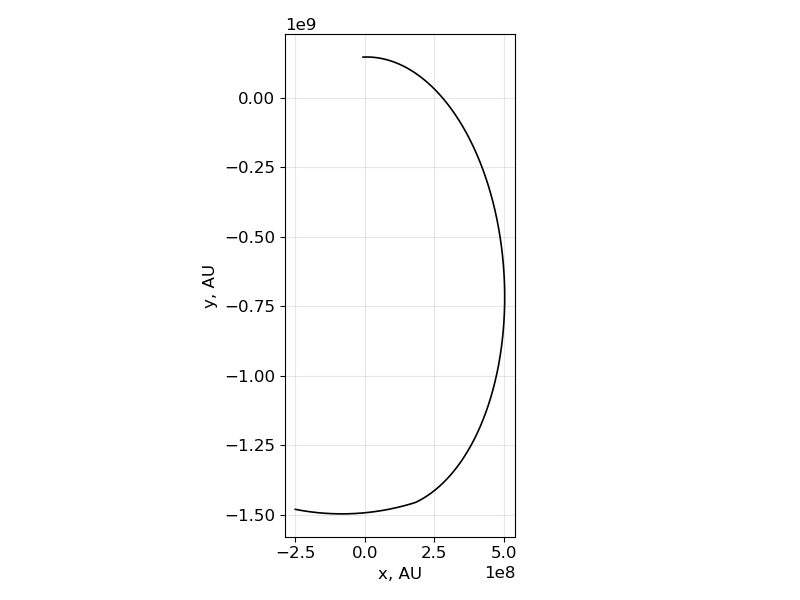

In [275]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1,1,figsize=(8,6))

# trajectory
ax.plot(coord_converted[1,:], coord_converted[2,:], c="black", lw=1.2)


ax.set(xlabel="x, AU", ylabel="y, AU")
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
# ax.set_xlim([-12,26])
# ax.set_ylim([-12,12])
# ax.legend()

plt.tight_layout(rect=[0, -0.0, 1, 1.0])
plt.show()

In [276]:
np.linalg.norm(coord_converted[1:4,0])/(1e3*pk.AU)

1.0036038849800222e-05

In [277]:
def array_to_file(ts, y, filepath):
    """Write ODE solution output to file

    Args:
        ts (np.array): length-N array of time-stamps (`sol.t`)
        y (np.array): 6-by-N array of states (`sol.y`)
        filepath (string): path to file being generated
    """
    nx, steps = y.shape
    assert len(ts) == steps
    assert nx == 6
    t_running = ts[0]

    # create file
    with open(filepath, 'w+') as file:
        file.write("epoch, x, y, z, vx, vy, vz\n")
        for idx,t in enumerate(ts):
            if t > t_running:
                file.write(f"{t}, {y[0,idx]}, {y[1,idx]}, {y[2,idx]}, {y[3,idx]}, {y[4,idx]}, {y[5,idx]}\n")
            t_running = t
    print(f"Finished exporting solution to {filepath}")
    return

In [279]:
array_to_file(coord_converted[0,:], coord_converted[1:,:], "./spice/baseline_outbound_SE.txt")

Finished exporting solution to ./spice/baseline_outbound_SE.txt


<IPython.core.display.Javascript object>


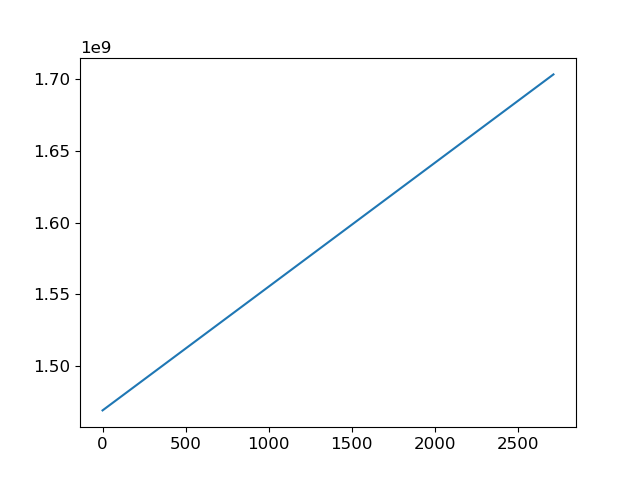

In [280]:
fig, ax = plt.subplots(1,1)
ax.plot(coord_converted[0,:])

plt.show()

In [281]:
coord_converted[0,:][0], coord_converted[0,:][1]

(1468707020.3596704, 1468793535.8256428)

In [282]:
# np.savetxt("./spice/baseline_outbound_EJS.txt", coord_converted, fmt='%.18e', 
#           delimiter=',', newline='\n', header='')

### Create SPICE

In [283]:
extraspicey.create_setup_file(
    "./spice/setup_outbound_SE.txt",
    LEAPSECONDS_FILE=os.path.join(os.environ.get("SPICE"), "lsk", "naif0012.tls"),
    OBJECT_NAME="TheORACLE",
    CENTER_ID=10,
    CENTER_NAME="SSB",
    REF_FRAME_NAME="ECLIPJ2000",
)

Generated ./spice/setup_outbound_SE.txt!


In [284]:
extraspicey.wrap_mkspk(
    filepath_set="./spice/setup_outbound_SE.txt",
    filepath_in="./spice/baseline_outbound_SE.txt",
    filepath_out="./spice/baseline_outbound_SE.bsp",
)

 
MKSPK -- Version 6.1.0, November 8, 2016 -- Toolkit Version N0067
 
Loading setup file ...
 
Processing setup file keyword values ...
 
Writing comments to the output SPK file  ...
 
Started processing input data ...
 
Writing last SPK segment ...
 
All done.
 
Successfully generated ./spice/baseline_outbound_SE.bsp!
